In [1]:
import numpy as np
import pandas as pd
import csv
import json
import requests
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler

2023-10-04 15:56:35.173950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# **** **** **** **** | Parameters: Global | **** **** **** ****

replicas_num = 3
consider_test_data_for_fpr_test = True



# **** **** **** **** | Parameters: Data sets | **** **** **** ****

# AE train data set
train_data_set_code = "normal_1_14"
test_data_set_code = "normal_24h"
test_data_set_code_for_fpr_test = "fpr-validation"

# AE test data set
test_data_set_code = "normal_test_24h"

# AE experimental data sets
test_data_set_general_codes = ["cpu-stress", "mem-leak", "pack-loss", "pack-delay", "pack-corr"]

if replicas_num > 1:
    test_data_set_codes = ["{code}-{replica}".format(code=ii, replica=jj) for ii in test_data_set_general_codes for jj in range(replicas_num)]
else:
    test_data_set_codes = test_data_set_general_codes
    
# Set of lists with the experiments schedules - [whole duration, fault injection point, failre point]
data_sets_config = {"normal_test_24h": [1440, 0, 0],
                    "cpu-stress-0": [45, 16, 42], "mem-leak-0": [60, 16, 51], "pack-loss-0": [30, 16, 25], "pack-delay-0": [30, 16, 25], "pack-corr-0": [30, 16, 24],
                    "cpu-stress-1": [45, 16, 40], "mem-leak-1": [60, 16, 43], "pack-loss-1": [30, 16, 22], "pack-delay-1": [30, 16, 24], "pack-corr-1": [30, 16, 28],
                    "cpu-stress-2": [45, 16, 42], "mem-leak-2": [60, 16, 49], "pack-loss-2": [30, 16, 23], "pack-delay-2": [30, 16, 23], "pack-corr-2": [30, 16, 25]}



# **** **** **** **** | Parameters: AE Model Training | **** **** **** ****

# Randomness
seed = 24

# Multiplicator for the number of nodes in the hidden layers of the AutoEncoder model
number_nodes_factor = 0.5

# Number of standard deviations to detect the anomalies (used both for detection on point and metric level) 
sigma = 3



# **** **** **** **** | Parameters: Anomaly Ranker | **** **** **** ****

# Anomaly Ranker server port
localizer_server_port = 5006

# Anomaly Ranker server address
server_address = "http://localhost:{localizer_server_port}"


# Percentage of the top ranked anomalous KPIs to consider for selection of suspicious nodes
rank_selection = 20

# Cluster node pairs
cluster_node_pairs_string = 'redis-1-1 redis-1-12, redis-1-2 redis-1-13, redis-1-3 redis-1-14, redis-1-4 redis-1-15, redis-1-5 redis-1-16, redis-1-6 redis-1-17, redis-1-7 redis-1-18, redis-1-8 redis-1-19, redis-1-9 redis-1-20, redis-1-10 redis-1-11'

# Create a list of the cluster's nodes pairs - cluster_node_pairs
cluster_node_pairs = cluster_node_pairs_string.split(", ")
for ii in range(len(cluster_node_pairs)):
    cluster_node_pairs[ii] = cluster_node_pairs[ii].split(" ")



# **** **** **** **** | Paths | **** **** **** ****

# Path to the preprocessed datasets
# data_set_file_path = "/Users/usi/DataHub/Data-Redis-2023/{data_set_code}_tuned/{data_set_code}.csv"
data_set_file_path = "resources/datasets/{data_set_code}_tuned/{data_set_code}.csv"

# Path to the .csv file with the initial list of features
features_file_path_initial = "resources/features/features_initial.csv"

# Path to the .csv file with the final list of features
features_file_path = "resources/features/features_final.csv"

# Path to the .txt file to save the anomalies in JSON
anomalies_file_path = "resources/anomalies/{data_set_code}.json"

# Path to the .csv file to save the AE point-level predictions
predictions_file_path = "resources/predictions-{approach}/{data_set_code}.csv"

# Path to the .txt file to save the localisations (output of the Anomaly Ranker)
localisations_file_path = "resources/localisations/{data_set_code}.csv"

# Path to the .txt file to save the node-pair level localisations report
localisations_by_pairs = "resources/localisations-pairs/{data_set_code}.csv"

# Path to the .csv file to save the Binary Anomaly Matrixes for Premise
bam_file_path = "resources/bams/{data_set_code}.csv"

# Path to the .csv file to save the Shuffled Binary Anomaly Matrixes for Premise
bam_shuffled_file_path = "resources/bams_shuffled/{data_set_code}-{cluster_node_pair_number}.csv"



# **** **** **** **** | Functions | **** **** **** ****

def get_predictions(loss_, threshold_):
    return tf.math.greater(loss_, threshold_),

def print_stats(predictions_, labels_):
    print("Accuracy = {}".format(accuracy_score(labels_, predictions_)))
    print("Precision = {}".format(precision_score(labels_, predictions_)))
    print("Recall = {}".format(recall_score(labels_, predictions_)))

def plot_samples(data_, minute_of_experiment_, title_):
    plt.grid()
    plt.plot(np.arange(len(data_[minute_of_experiment_])), data_[minute_of_experiment_][:])
    plt.title(title_)
    plt.show()

def plot_loss_distribution(loss_, title_, color_="skyblue"):
    plt.figure(figsize=(10, 5))
    plt.hist(loss_[None,:], bins=50, color=color_)
    plt.xlabel("Loss (reconstruction error)")
    plt.ylabel("Number of points")
    plt.title(title_)
    plt.show()

def get_threshold(loss_, verbose=False):
    threshold_up = np.mean(loss_) + sigma * np.std(loss_)
    threshold_down = np.mean(loss_) - sigma * np.std(loss_)
    if verbose:
        print("Mean:", np.mean(loss_),"Std Deviation:", np.std(loss_),  "Threshold UP: ", threshold_up,  "Threshold DOWN: ", threshold_down)
    
    return round(np.mean(loss_), 2), round(np.std(loss_), 2), round(threshold_up, 2), round(threshold_down, 2)


# Premise -> Bam Shuffling: kpi => metric
def get_metric_from_kpi(kpi_):
    kpi_components_list_ = kpi_.split("_")
    metric_ = "_".join(kpi_components_list_[1:])

    return metric_

# Premise -> Bam Shuffling: kpi, new_recourse -> new_kpi
def change_node_in_kpi(kpi_, new_recourse_):
    metric_ = get_metric_from_kpi(kpi_)
    new_kpi_ = new_recourse_ + "_" + metric_

    return new_kpi_



# **** **** **** **** | Autoencoder model architecture | **** **** **** ****

class AnomalyDetector(Model):
    def __init__(self, number_of_columns_, factor_):
        super(AnomalyDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            # layers.Dense(int(number_of_columns_ * factor_), activation="tanh", kernel_regularizer=regularizers.l1(0.001)),
            layers.Dense(int(number_of_columns_ * factor_), activation="tanh", kernel_regularizer=regularizers.l1(0.002)),
            layers.Dense(int(number_of_columns_ * factor_ * factor_), activation="tanh", kernel_regularizer=regularizers.l1(0.002)),
            layers.Dense(int(number_of_columns_ * factor_ * factor_ * factor_), activation="tanh"),
            # layers.Dense(int(number_of_columns_ * factor_ * factor_ * factor_ * factor_), activation="tanh")
        ])

        self.decoder = tf.keras.Sequential([
            # layers.Dense(int(number_of_columns_ * factor_ * factor_ * factor_), activation="tanh"),
            layers.Dense(int(number_of_columns_ * factor_ * factor_), activation="tanh"),
            layers.Dense(int(number_of_columns_ * factor_), activation="tanh"),
            layers.Dense(int(number_of_columns_), activation="tanh")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
#### Prepare Training Data Set

# Load KPI names
df_tmp = pd.read_csv(features_file_path, sep=',', header=None)
feature_set = df_tmp[0].values

# Load Training Data Set
train_df_all = pd.read_csv(data_set_file_path.format(data_set_code=train_data_set_code))

# Create a numpy.ndarray of the frame's values
train_data_all = train_df_all.values.astype(float)

# Create labels
train_labels_all = np.asarray([0 for ii in range(len(train_data_all))]).astype(bool)

# Create Train/Validation Data/Labels arrays
train_data, val_data, train_labels, val_labels = train_test_split(train_data_all, train_labels_all, test_size=0.2, random_state=seed)

# Build the scaler
scaler = MinMaxScaler()
scaler.fit(train_data)

# Normalize the datasets
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)

# Transform the Training/Validation data sets to pandas data frames
train_df = pd.DataFrame(train_data, columns=list(train_df_all.columns))
val_df = pd.DataFrame(val_data, columns=list(train_df_all.columns))

# Print summary of the Training/Validation data sets
# print(len(train_data), len(train_labels), len(val_data), len(val_labels))

# Plot training/validation samples
# plot_samples(train_data, 10, "Training data sample")
# plot_samples(val_data, 10, "Validation data sample")

2023-10-04 15:56:45.108109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
32/32 [==============================] - 3s 41ms/step - loss: 451.1886 - val_loss: 245.4883
Epoch 2/40
32/32 [==============================] - 1s 31ms/step - loss: 241.7828 - val_loss: 239.7572
Epoch 3/40
32/32 [==============================] - 1s 31ms/step - loss: 239.0636 - val_loss: 238.4113
Epoch 4/40
32/32 [==============================] - 1s 31ms/step - loss: 238.0214 - val_loss: 237.5771
Epoch 5/40
32/32 [==============================] - 1s 30ms/step - loss: 237.2806 - val_loss: 236.9131
Epoch 6/40
32/32 [==============================] - 1s 30ms/step - loss: 236.6602 - val_loss: 236.3315
Epoch 7/40
32/32 [==============================] - 1s 30ms/step - loss: 236.1035 - val_loss: 235.7974
Epoch 8/40
32/32 [==============================] - 1s 30ms/step - loss: 235.5845 - val_loss: 235.2930
Epoch 9/40
32/32 [==============================] - 1s 29ms/step - loss: 234.7397 - val_loss: 233.9121
Epoch 10/40
32/32 [==============================] - 1s 30ms/step - loss:

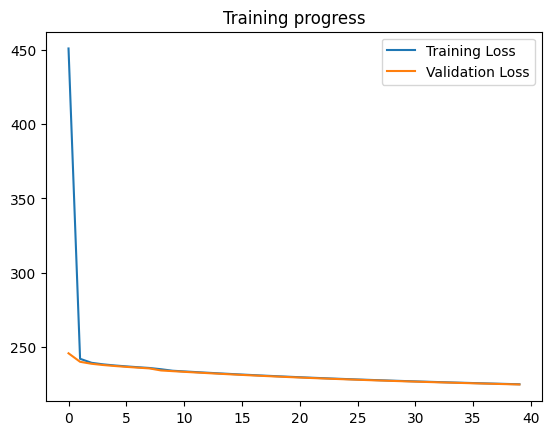

In [4]:
#### Train the AutoEncoder Model

# Set the randomness seed
tf.keras.utils.set_random_seed(seed)

# Build the model
autoencoder = AnomalyDetector(len(train_df_all.columns), number_nodes_factor)

# Compile the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.KLDivergence())

# Train the model
history = autoencoder.fit(
    train_data,
    train_data,
    epochs=40,
    batch_size=512,
    validation_data=(val_data, val_data),
    use_multiprocessing=False,
    shuffle=False
)

# Plot the training history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training progress")
plt.legend()

In [5]:
#### Calculate the Metric-level Reconstruction Error Thresholds (thresholds_per_metric_up)

# Get the reconstructions for each KPI of each point of the Training data (output: list of lists of the reconstructed KPIs)
reconstructions = autoencoder.predict(train_data)

# Build a reconstructions data frame
reconstructions_df = pd.DataFrame(reconstructions, columns=list(train_df_all.columns))

# Calculate a Reconstruction Error on Training Data for each metric (output: list of MSE's for each metric)
reconstruction_errors_df = np.abs(reconstructions_df - train_df)

# Collect the Metric-level Thresholds
thresholds_per_metric_up = []
thresholds_per_metric_down = []

for col_idx, col in enumerate(reconstruction_errors_df.columns):
    metric_mean, metric_stdev, metric_threshold_up, metric_threshold_down = get_threshold(reconstruction_errors_df[col])
    thresholds_per_metric_up.append(metric_threshold_up)
    thresholds_per_metric_down.append(metric_threshold_down)

504/504 [==============================] - 2s 3ms/step


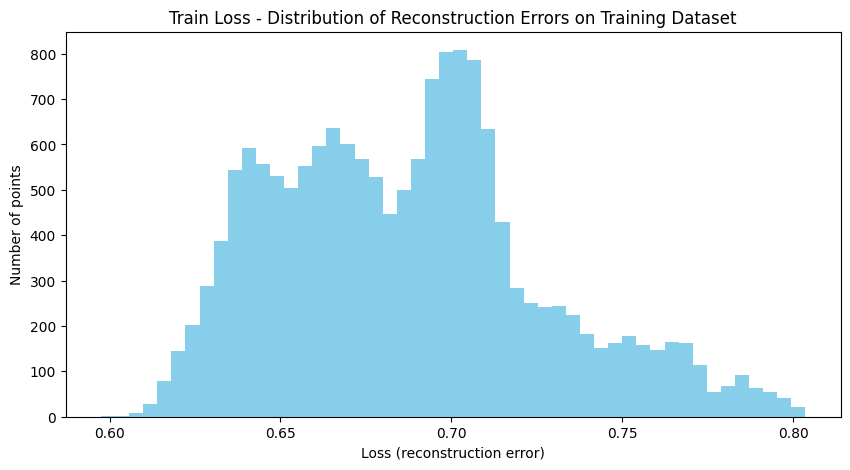

Mean: 0.6871517360847865 Std Deviation: 0.03922246800619024 Threshold UP:  0.8048191401033572 Threshold DOWN:  0.5694843320662158


In [6]:
#### Calculate the Point-level Reconstruction Error Threshold - threshold_up

# Calculate a Reconstruction Error on Training Data for each point (output: list of MSE's for each point)
loss = tf.keras.losses.mse(reconstructions, train_data)

# Plot the distribution of reconstruction errors on the training data (Training loss)
plot_loss_distribution(loss, "Train Loss - Distribution of Reconstruction Errors on Training Dataset")

# Calculate the Point-level Anomaly Threshold (the deviation threshold of the Point's MSE) basing on the Training Loss
point_level_mean, point_level_stdev, threshold_up, threshold_down  = get_threshold(loss, True)

In [7]:
#### Make AE Reconstructions on Experimental Data with seeded anomalies

the_test_data_set_codes = test_data_set_codes.copy()

if consider_test_data_for_fpr_test:
    the_test_data_set_codes.append(test_data_set_code_for_fpr_test)

test_data_sets = []
test_reconstructions = []

for test_data_set_code in the_test_data_set_codes:
    
    # Download the data set
    test_df = pd.read_csv(data_set_file_path.format(data_set_code=test_data_set_code))

    # Create a numpy.ndarray of the frame's values
    test_data = test_df.values
    test_data = test_data.astype(float)

    # Normalize the test data
    test_data = scaler.transform(test_data)
    
    #!! Add the data set to the list of the normalized test data sets
    test_data_sets.append(test_data)
    
    # Make AE Predictions - Get the KPIs'reconstructions of each point (output: list of lists of the reconstructed metrics)
    the_reconstructions = autoencoder.predict(test_data)
    
    #!! Add the reconstructions to the list of reconstructions on the test data sets
    test_reconstructions.append(the_reconstructions)

315/315 [==============================] - 1s 3ms/step


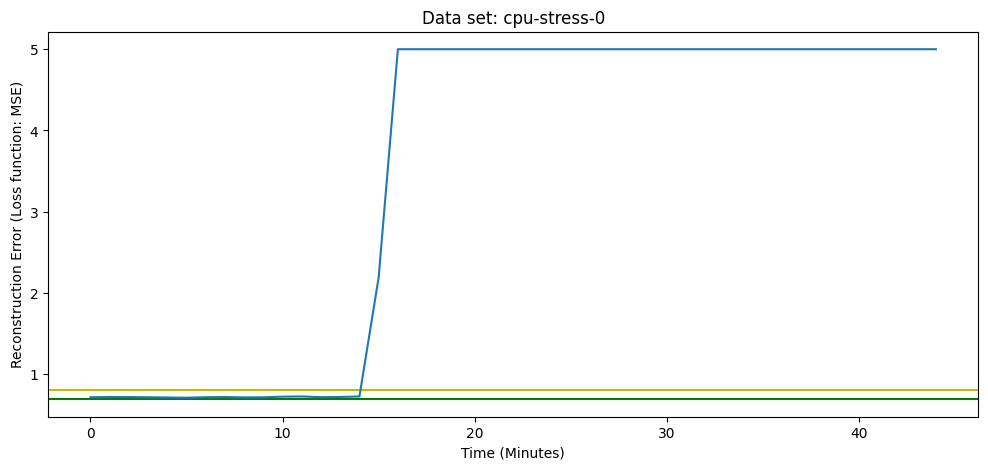

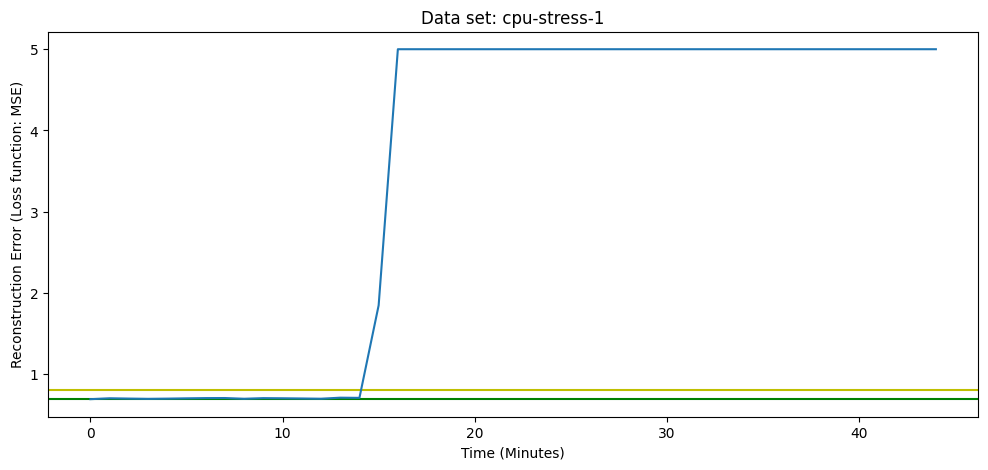

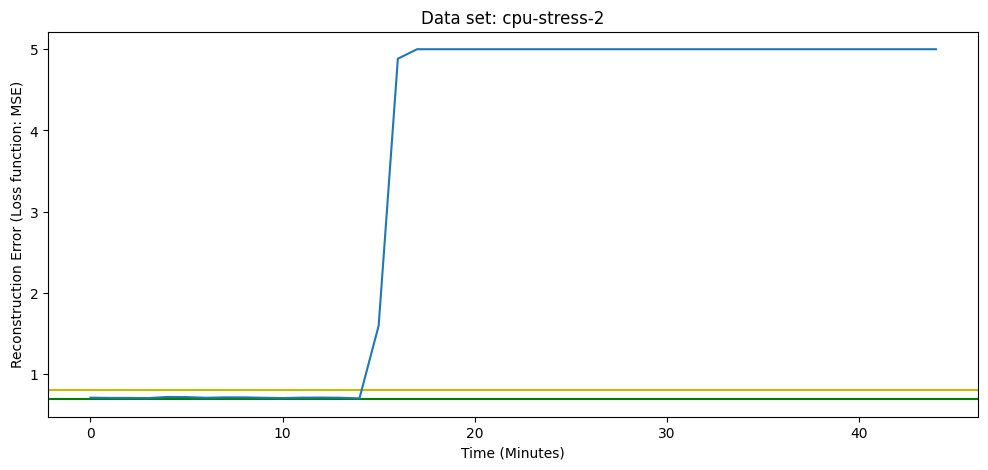

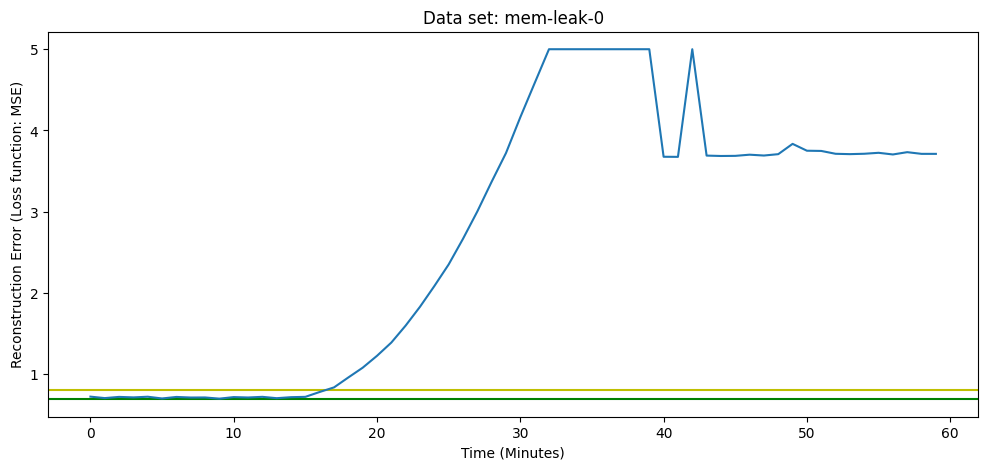

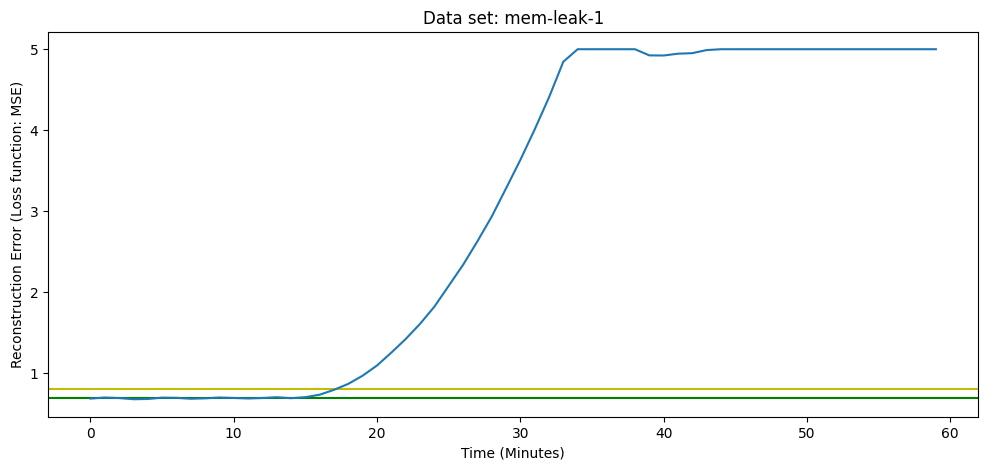

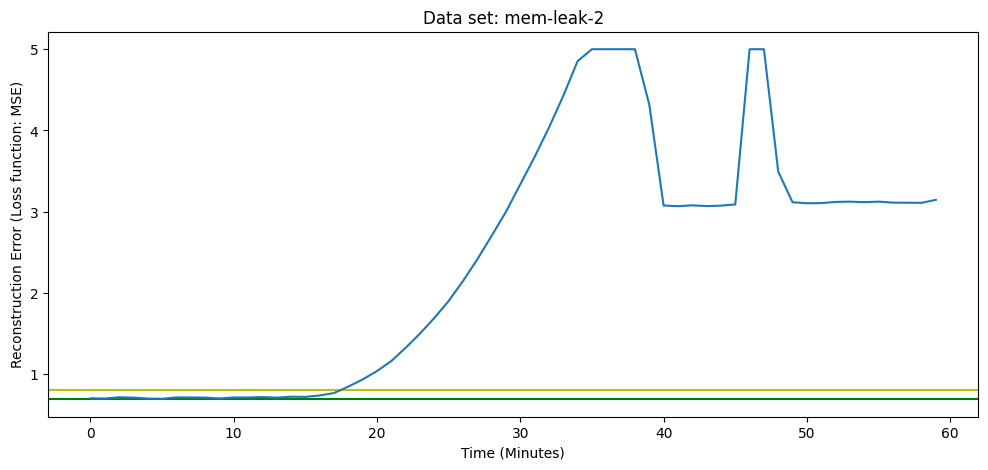

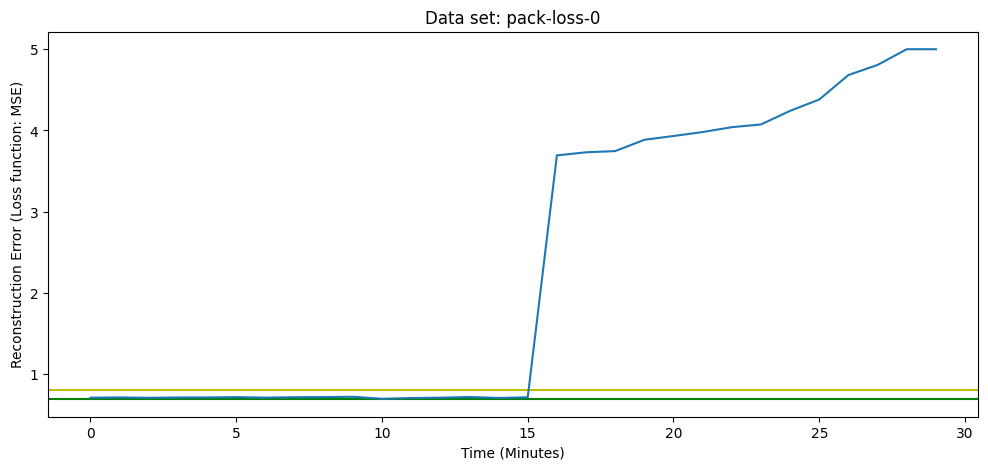

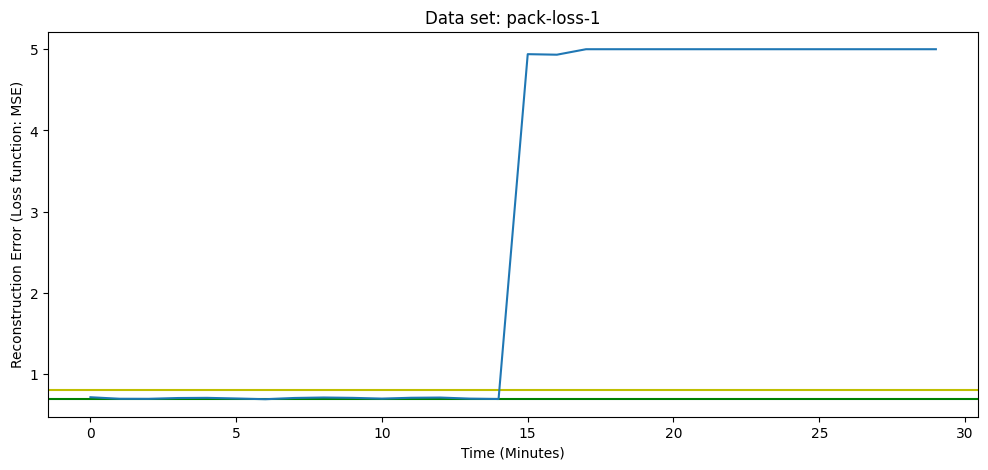

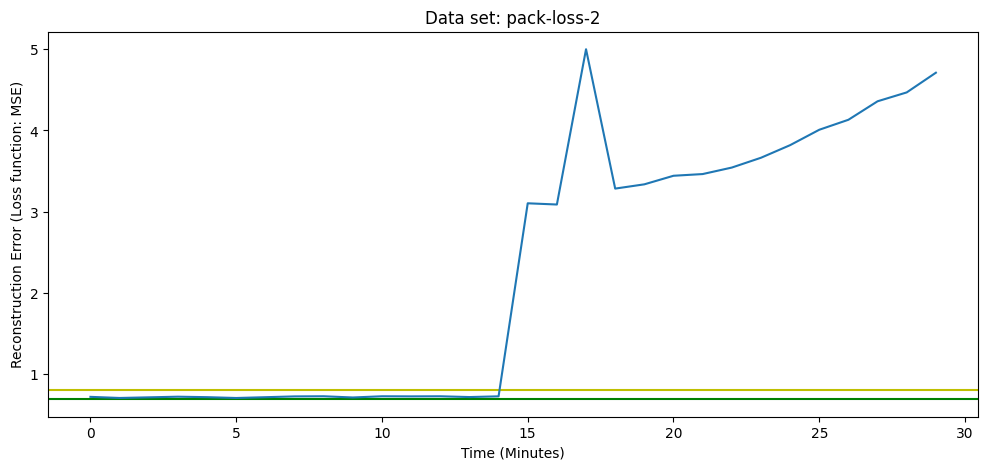

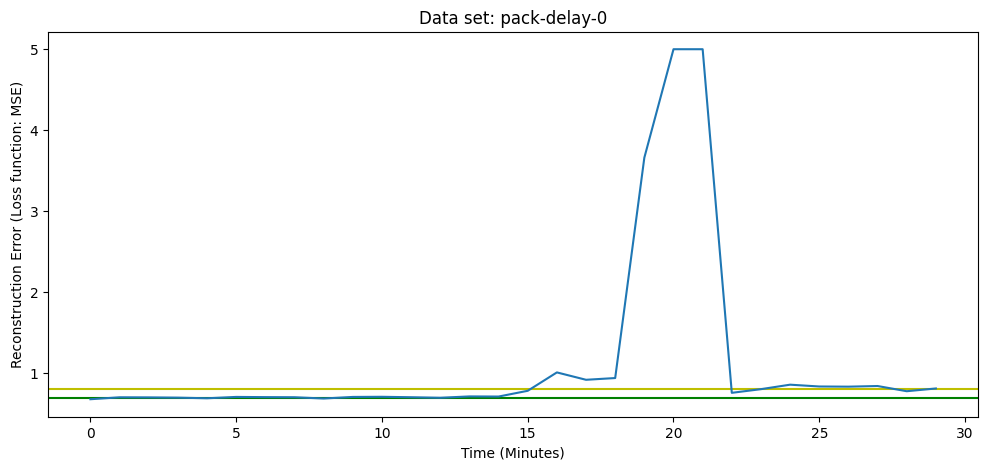

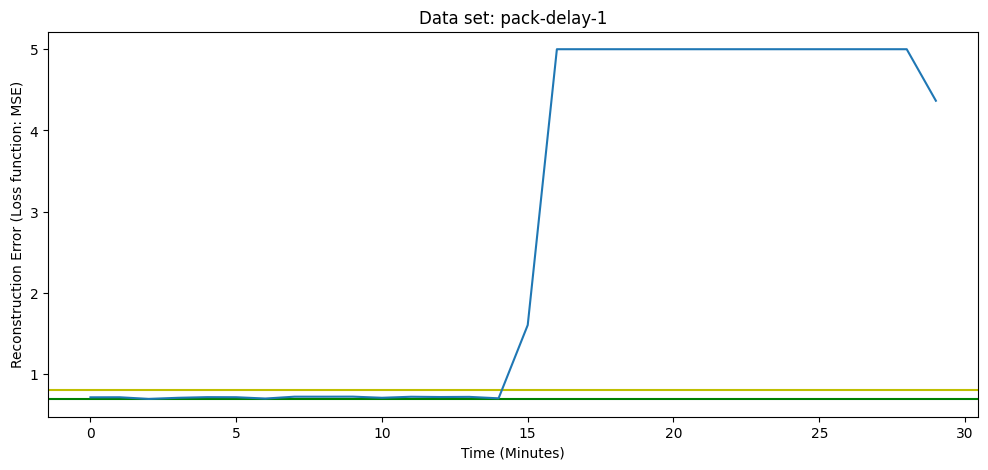

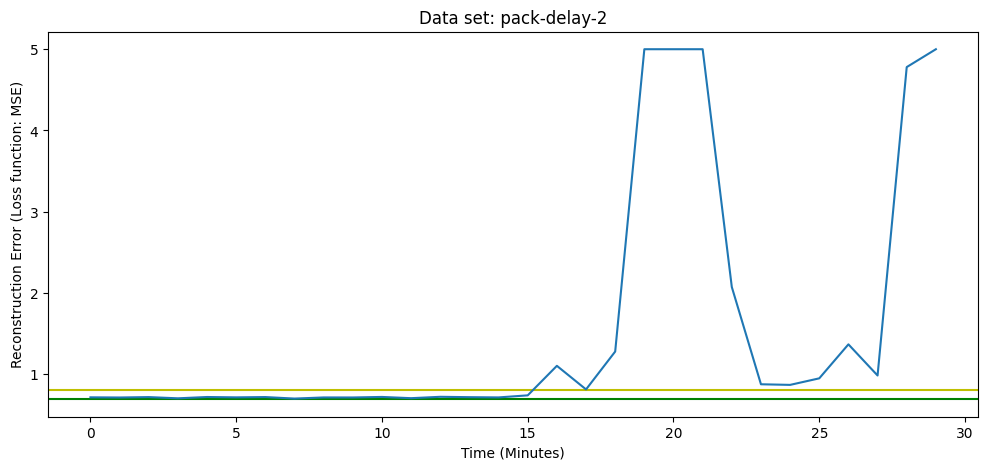

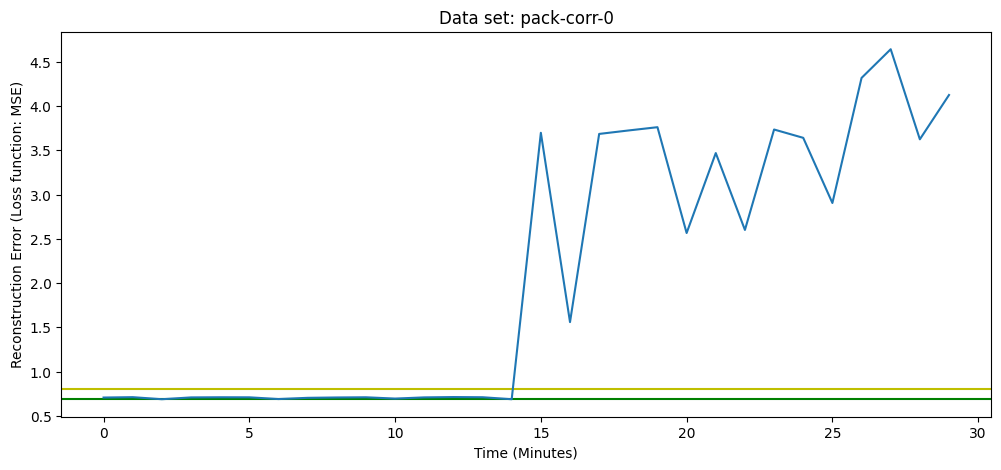

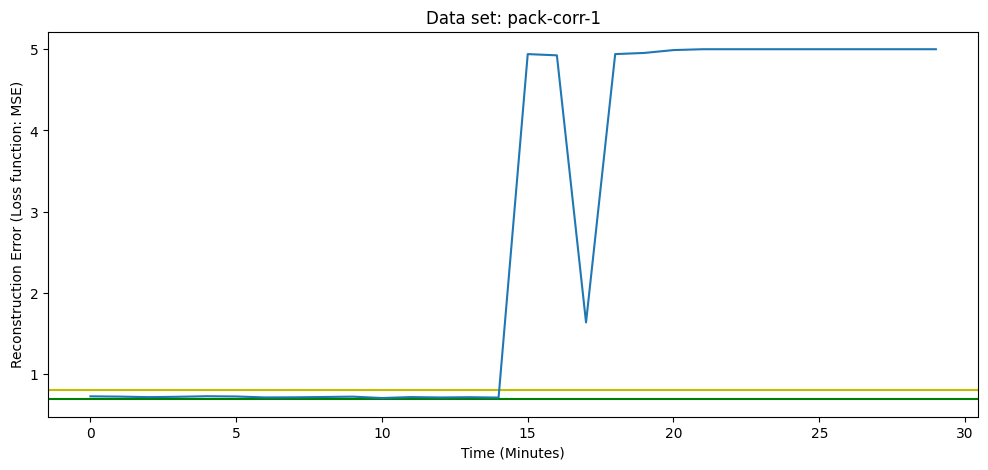

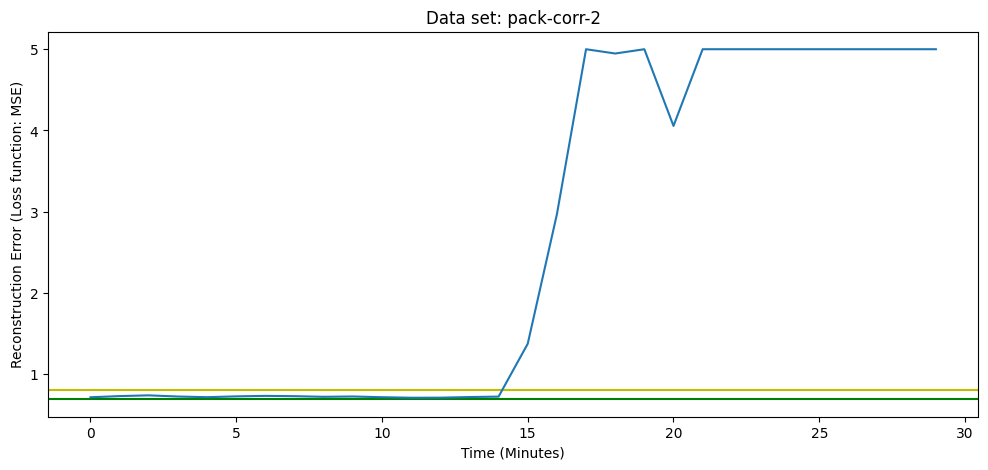

In [8]:
#### Detect point-level anomalies (predictions), save, and visualize

the_test_data_set_codes = test_data_set_codes.copy()
if consider_test_data_for_fpr_test:
    the_test_data_set_codes.append(test_data_set_code_for_fpr_test)

for test_data_set_idx, test_data_set_code in enumerate(the_test_data_set_codes):

    # Calculate a point-level reconstruction errors (output: list of MSE's for each point)
    test_point_reconstruction_errors = tf.keras.losses.mse(test_reconstructions[test_data_set_idx], test_data_sets[test_data_set_idx])
  
    # Classify a point as an anomaly if its reconstruction error is greater than the point-level threshold (output: list of predictions per each point)
    test_predictions = get_predictions(test_point_reconstruction_errors, threshold_up)
    test_predictions = np.array(test_predictions)[0]

    # Save the preditions (point level anomalies)
    test_predictions_bin = [int(prediction) for prediction in test_predictions]
    with open(predictions_file_path.format(data_set_code=test_data_set_code, approach="a"), 'w') as f:
        write = csv.writer(f)
        for prediction_bin in test_predictions_bin:
            write.writerow([prediction_bin])
            
    # Vizualize the preditions
    
    # Exclude the normal data set user for FPR estimation
    if test_data_set_code not in test_data_set_codes:
        continue

    # Cut the recinstruction error value from top for the point-level visualization purposes
    point_level_re_for_visualisation = []
    for point_re in test_point_reconstruction_errors:
        if point_re > 5:
            point_re = 5
        point_level_re_for_visualisation.append(point_re)

    # Visualize the point-level reconstruction errors
    plt.figure(figsize = (12, 5))
    plt.title("Data set: {data_set_code}".format(data_set_code=test_data_set_code))
    plt.xlabel("Time (Minutes)")
    plt.ylabel("Reconstruction Error (Loss function: MSE)")
    plt.axhline(y = point_level_mean, color = 'g', linestyle = '-')
    plt.axhline(y = threshold_up, color = 'y', linestyle = '-')
    plt.plot(np.arange(len(point_level_re_for_visualisation)), point_level_re_for_visualisation)
    plt.show()

In [9]:
#### Detect metric-level anomalies and save in JSON for Anomaly Ranker

the_test_data_set_codes = test_data_set_codes.copy()

if consider_test_data_for_fpr_test:
    the_test_data_set_codes.append(test_data_set_code_for_fpr_test)

for test_data_set_idx, test_data_set_code in enumerate(the_test_data_set_codes):

    # Calculate the reconstruction errors for each KPI's value within each point
    test_reconstruction_errors = np.abs(test_reconstructions[test_data_set_idx] - test_data_sets[test_data_set_idx])

    # Create a two-dim array of anomalies (sets of anomalous KPIs for each point) in JSON format - anomalous_kpis_json
    anomalous_kpis_json = []
    for current_timestamp, point__ in enumerate(test_reconstruction_errors):

        anomalous_kpis_json_one_point  = []
        for kpi_index, kpi_re in enumerate(point__):

            kpi_re_above_threshold = kpi_re - thresholds_per_metric_up[kpi_index]
            if kpi_re_above_threshold >= 0:
                
                kpi_components_list = feature_set[kpi_index].split("_")
                kpi_node = kpi_components_list[0]
                kpi_metric = "_".join(kpi_components_list[1:])
                
                anomalous_kpis_json_one_point.append({
                    'timestamp': 1522751098000,
                    'resource': {
                        'name': kpi_node,
                    },
                    'metric': {
                        'name': kpi_metric,
                    },
                    'value': kpi_re_above_threshold/thresholds_per_metric_up[kpi_index],
                    'kpi_index': kpi_index
                })

        # Append an anomalies to the JSON data structure
        anomalous_kpis_json.append(anomalous_kpis_json_one_point)

    # Save anomalies in JSON format
    with open(anomalies_file_path.format(data_set_code=test_data_set_code), "w") as outfile:
        json.dump(anomalous_kpis_json, outfile)
        outfile.close()

In [10]:
#### Rank Anomalies and save the Rankings (Raw Localizations)

the_test_data_set_codes = test_data_set_codes.copy()

if consider_test_data_for_fpr_test:
    the_test_data_set_codes.append(test_data_set_code_for_fpr_test)

for test_data_set_code in the_test_data_set_codes:

    # Load anomalies
    with open(anomalies_file_path.format(data_set_code=test_data_set_code)) as json_file:
        anomalous_kpis_json = json.load(json_file)

    with open(localisations_file_path.format(data_set_code=test_data_set_code), "w") as file_out:
        localisations_writer = csv.writer(file_out)

        for i in range(len(anomalous_kpis_json)):
            data = {"anomalies": anomalous_kpis_json[i]}

            # Rank KPIs and localise the faulty/suspected nodes
            response = requests.post(server_address.format(localizer_server_port=localizer_server_port) + '/localize?rank_selection=' + str(rank_selection) + '&data_set_code='  + str(test_data_set_code) + '&minute=' + str(i), json=data, headers={"Content-Type": "application/json"})
            response_content_decoded = json.loads(response.content)

            localization_row = [str(i), response_content_decoded["localization"]]

            for item in response_content_decoded["suspected_list"]:
                localization_row.append(item[0])
                localization_row.append(item[1])

            # Save raw localizations
            localisations_writer.writerow(localization_row)


In [11]:
#### Create BAMs - for Premise

for test_data_set_code in test_data_set_codes:
    
    #### Data Preparation --------------------------------------------------------------------
    
    # Download the test dataset
    test_df = pd.read_csv(data_set_file_path.format(data_set_code=test_data_set_code))

    # Create a numpy.ndarray of the frame's values
    test_data = test_df.values
    test_data = test_data.astype(float)

    # Normalize test data
    test_data = scaler.transform(test_data)
    
    #### Make AE Predictions - Get the KPIs'reconstructions of each point (output: list of lists of the reconstructed metrics)
    test_reconstructions = autoencoder.predict(test_data)

    #### Create/Save BAM (Binary Anomaly Matrix) for Premise -------------------------------------------------------

    # Calculate the Metric-level reconstruction errors
    test_data_df = pd.DataFrame(test_data)
    reconstructions_df = pd.DataFrame(test_reconstructions)
    
    # Build a reconstruction errors frame
    reconstruction_errors_fd = np.abs(reconstructions_df - test_data_df)

    # Convert a reconstruction errors frame to array
    reconstruction_errors_array = reconstruction_errors_fd.values
    reconstruction_errors_array = reconstruction_errors_array.astype(float)

    # Init the Binary Anomaly Matrix with zeros
    anomalies_array = np.zeros((len(reconstruction_errors_array), len(train_df.columns)), dtype=int)
    
    # Fulfil the Binary Anomaly Matrix based on the reconstruction error and the reconstruction error threshold for  each metric
    # Loop by time points
    for ii in range(len(reconstruction_errors_array)):
        # Loop by metrics
        for jj in range(len(reconstruction_errors_array[ii])):
            metric_threshold_up = thresholds_per_metric_up[jj]

            # Compare the metric's reconstruction error with the metric's threshold
            if reconstruction_errors_array[ii][jj] > metric_threshold_up:
                anomalies_array[ii][jj] = 1
            else:
                anomalies_array[ii][jj] = 0

    # Save BAM
    initial_features_list = []
    with open(features_file_path_initial, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        for da in data:
            initial_features_list.append(da[0])  
    
    # Patch
    # TODO: To Fix the text string format problem
    initial_features_list[0] = "redis-1-1_system.network.in.bytes"

    cutted_features_list = []
    with open(features_file_path, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        for da in data:
            cutted_features_list.append(da[0])       
    
    # Patch
    # TODO: To Fix the text string format problem
    cutted_features_list[0] = "redis-1-1_system.network.in.bytes"

    
    with open(bam_file_path.format(data_set_code=test_data_set_code), "w") as file_out:
        csv_writer = csv.writer(file_out)
        
        csv_row = ["timestamp"]
        
        for cc in initial_features_list:
            csv_row.append(cc)
        
        csv_row.append("class")
        csv_writer.writerow(csv_row)

        for ii in range(len(anomalies_array)):
            
            if data_sets_config[test_data_set_code][1] == 0: # normal data
                class_name = "n"
            else:   
                if ii + 1 < int(data_sets_config[test_data_set_code][1]):
                    class_name = "n"
                else:
                    if ii + 1 < int(data_sets_config[test_data_set_code][2]):
                        class_name = test_data_set_code
                    else:
                        continue
                    
            csv_row = []
            csv_row.append(str(ii + 1))
            
            for feature_from_initial in initial_features_list:
                try:
                    index_in_cutted_features_list = cutted_features_list.index(feature_from_initial)
                    the_value = anomalies_array[ii][index_in_cutted_features_list]
                except ValueError:
                    the_value = 0
                
                csv_row.append(str(the_value))

            csv_row.append(class_name) 
            csv_writer.writerow(csv_row)

1/1 [==============================] - 0s 35ms/step


In [12]:
#### Shuffle BAMs (for Premise)

# Loop by the anomalies data sets
for data_set_idx, data_set_code in enumerate(test_data_set_codes):

    replication = int(data_set_code[-1])
    
    if replication == 0:
        faulty_pair_index = 9

    if replication == 1:
        faulty_pair_index = 1

    if replication == 2:
        faulty_pair_index = 2

        # Patch
        if data_set_code == "pack-delay-2":
            faulty_pair_index = 1

    # Determine the fault master/slave node names
    faulty_master = cluster_node_pairs[faulty_pair_index][0]
    faulty_slave = cluster_node_pairs[faulty_pair_index][1]
    
    # Source file (BAM)
    df_original = pd.read_csv(bam_file_path.format(data_set_code=data_set_code))
    
    # Original Header
    header_original = list(df_original.columns)[1 : -1]
    
    # Loop by the cluster's node pairs
    for jj in range(0, len(cluster_node_pairs)):
        
        # Target file path
        anomalies_shuffled_file_path = bam_shuffled_file_path.format(data_set_code=data_set_code, cluster_node_pair_number=str(jj))
        
        # If the pair is the faulty one
        if jj == faulty_pair_index:
            df_original.to_csv(anomalies_shuffled_file_path, index=False)
            continue

        # The names of the the nodes from the current pair
        target_master = cluster_node_pairs[jj][0]
        target_slave = cluster_node_pairs[jj][1]
        
        # Create a new header
        header_new = []
        for kpi in header_original:
            node = kpi.split("_")[0]

            if node == target_master:
                kpi_new = change_node_in_kpi(kpi, faulty_master)

            if node == target_slave:
                kpi_new = change_node_in_kpi(kpi, faulty_slave)

            if node == faulty_master:
                kpi_new = change_node_in_kpi(kpi, target_master)

            if node == faulty_slave:
                kpi_new = change_node_in_kpi(kpi, target_slave)

            header_new.append(kpi_new)
        
        df_new = df_original
        df_new.to_csv(anomalies_shuffled_file_path, index=False)